# <h2 align="center">DLOps - Configuração<h2>

Data Scientist.: PhD.Eddy Giusepe Chirinos Isidro

Como já sabemos o que é DLOps, como versionar nosso Dataset, agora vamos treinar nossos primeiros modelos. Para essa tarefa vamos a usar a biblioteca de [Pytorch Lightning](https://pytorch-lightning.readthedocs.io/en/latest/), a qual é uma biblioteca de código aberto que nos permite treinar modelos por acima de [Pytorch](https://pytorch.org/) oferecendo muitíssima funcionalidade extra que nos fará a vida mais fácil à hora de treinar e gerenciar nossos modelos.  

# Primeiro treinamento

O seguinte código nos permite treinar um primeiro modelo com o Dataset [MNIST](http://yann.lecun.com/exdb/mnist/). Vamos começar com um classificador binário simples que detecte apenas o dígito $3$ (mais para frente usaremos todo o Dataset para uma classificação Multiclasse, aprendendo pelo caminho como gerar novas versões do Dataset e receitas do treinamento). O modelo que usaremos será um Perceptron Multicapa (MLP) simples.

In [2]:
# Importando as nossas bibliotecas 

import pytorch_lightning as pl 
from torch.utils.data import Dataset, DataLoader
from skimage.io import imread
import torch 
import pandas as pd
from glob import glob

In [3]:
class MSNITDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = imread(self.images[idx])
        return torch.from_numpy(img), self.labels[idx]

In [4]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, path, batch_size):
        super().__init__()
        self.path = path
        self.batch_size = batch_size
    def generate_df(self, l1, l2):
        return pd.DataFrame({
            'image': l1 + l2, 
            'label': [1] * len(l1) + [0] * len(l2)
        })
    def setup(self, stage = None):
        train_3 = glob(str(self.path / 'train' / '3' / '*.png'))
        train_no3 = glob(str(self.path / 'train' / 'no3' / '*.png'))
        self.train_df = self.generate_df(train_3, train_no3)
        test_3 = glob(str(self.path / 'test' / '3' / '*.png'))
        test_no3 = glob(str(self.path / 'test' / 'no3' / '*.png'))
        self.test_df = self.generate_df(test_3, test_no3)
        self.train_ds = MSNITDataset(self.train_df.image.values, self.train_df.label.values)
        self.test_ds = MSNITDataset(self.test_df.image.values, self.test_df.label.values)
    def train_dataloader(self):
        return DataLoader(self.train_ds, shuffle=True, batch_size=self.batch_size)
    def val_dataloader(self, batch_size=None, shuffle=False):
        return DataLoader(
            self.test_ds, 
            batch_size=self.batch_size if batch_size is None else batch_size,
            shuffle=shuffle
        )


In [6]:
from pathlib import Path

path = Path('dataset')

dm = MNISTDataModule(path, batch_size=25)
dm.setup()

imgs, labels = next(iter(dm.train_dataloader()))

imgs.shape, imgs.dtype, imgs.max(), imgs.min(), labels.shape

(torch.Size([25, 28, 28]),
 torch.uint8,
 tensor(255, dtype=torch.uint8),
 tensor(0, dtype=torch.uint8),
 torch.Size([25]))

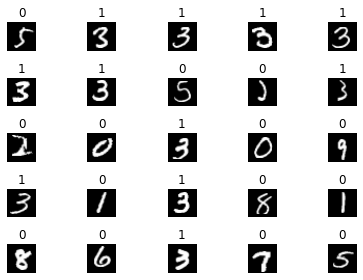

In [7]:
import matplotlib.pyplot as plt

r, c = 5, 5 
fig, axs = plt.subplots(r, c)
imgs, labels = next(iter(dm.train_dataloader()))
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(imgs[i * c + j], cmap='gray')
        axs[i, j].set_title(labels[i * c + j].item())
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [8]:
import torch.nn as nn
import torch.nn.functional as F



class MNISTModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(28 * 28, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        x = x.float() / 255 
        return self.mlp(x.view(x.size(0), -1)).squeeze(-1)

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            return torch.sigmoid(self(x))

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        preds = torch.sigmoid(y_hat) > 0.5
        acc = (preds.long() == y).float().mean()
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, y.float())
        preds = torch.sigmoid(y_hat) > 0.5
        acc = (preds.long() == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

In [9]:
module = MNISTModule()
module

MNISTModule(
  (mlp): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [10]:
output = module(imgs)
output.shape

torch.Size([25])

In [12]:
dm = MNISTDataModule(path, batch_size=25)
module = MNISTModule()
trainer = pl.Trainer(
    max_epochs=10,
    logger=None,
    enable_checkpointing=False,
    # overfit_batches=1,
)



trainer.fit(module, dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 78.6 K
------------------------------------
78.6 K    Trainable params
0         Non-trainable params
78.6 K    Total params
0.314     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Tal como mostra a célula anterior durante $10$ épocas, conseguimos um modelo com um $95\%$ de acuracy nos Dados de test.

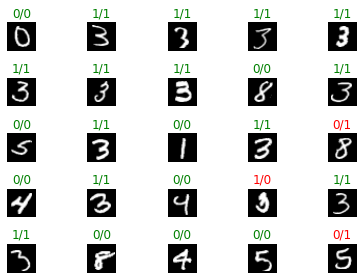

In [13]:
r, c = 5, 5 
fig, axs = plt.subplots(r, c)
imgs, labels = next(iter(dm.val_dataloader(25, True)))
preds = module.predict(imgs) > 0.5
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(imgs[i * c + j], cmap='gray')
        label = labels[i * c + j].item()
        pred = preds[i * c + j].long().item()
        axs[i, j].set_title(f'{label}/{pred}', color = 'green' if label == pred else 'red')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()


# Script de Treinamento

É necessário usar `scripts de Python` para escalar o treinamento. Para isso podemos seguir a seguinte distribuição:

* `main.py`: contém o código de treinamento

* `src`: contém os arquivos de código de Pytorch Lightning

    * `dm`: contém o LightningDataModule

    * `module`: contém o LightningModule

Para nosso primeiro caso é suficiente, mas a medida que um projeto vaja cescrendo é possível que seja necessário ir adicionando arquivos na pasta `src`, *por exemplo:* para separar os Datasets e modelos ou adicionar funcionalidades extras num arquivo `utils.py`.   

A seguir temos o código de treinamento (conteúdo do arquivo `main.py`)




In [ ]:
from src import *
from pathlib import Path
import pytorch_lightning as pl

path = Path('dataset')
dm = MNISTDataModule(path, batch_size=25)
module = MNISTModule()
trainer = pl.Trainer(
    max_epochs=10,
    logger=None,
    enable_checkpointing=False,
    # overfit_batches=1,
)
trainer.fit(module, dm)

Que pode ser executado com o comando:

```
python main.py
```

Isto treinará nosso modelo da mesma maneira que vimos anteriormente. No entanto, isto é muito útil já que sempre treinaremos o mesmo modelo (o qual ainda não estamos salvando). Precisaremos dotar de flexibilidade a nosso `script` ademais de querer `trackear` todo o que vamos fazendo. Isto será possível com um arquivo de `configuração`.


# Arquivo de configuração

Existem diferentes alternativas à hora de executar treinamentos com arquivos de configuração. Uma biblioteca bastante utilizada é [Hydra](https://hydra.cc/docs/intro/). Mas aqui usaremos a minha maneira que até agora sempre me funcionou bem.

## Configuração base

O primeiro que precisamos é uma configuração base na que definiremos todos os parâmetros por defeito que queremos usar em nosso treinamento.

In [ ]:
config = {
    'datamodule': {
        'path': Path('dataset'),
        'batch_size': 25
    },
    'trainer': {
        'max_epochs': 10,
        'logger': None,
        'enable_checkpointing': False,
        'overfit_batches': 0
    }
}

dm = MNISTDataModule(**config['datamodule'])
module = MNISTModule()
trainer = pl.Trainer(**config['trainer'])
trainer.fit(module, dm)

Utilizando o operador `**` podemos passar um dicionário de parâmetros a uma função.

> Te recomendo não usar parâmetros por defeito em teus `modules`, já que isto pode causar problemas a longo prazo. É um pouco mais tedioso mas vale a pena para `trackear` todos os parâmetros usados no treinamento.

# Sobrescrever a configuração base

Agora o que faremos será criar um arquivo de `config.yml` que contenha a configuração que queremos usar em nosso treinamento. Para não ter que escrever todo o código de configuração, simplesmente definiremos aqueles parâmetros que queremos modificar da configuração base. Desta maneira, nosso projeto ficará assim:


- `main.py`: contém o código de treinamento
- `config.yml`: contém a configuração do treinamento
- `src`: contém os arquivos do código de Pytorch Lightning
    - `dm.py`: contém o LightningDataModule
    - `module.py`: contém o LightningModule
    - `utils.py`: contém funções úteis

o seguinte exemplo fará um treinamento durante mais epochs e com um `batch_size` mais grande.

```
datamodule:
  batch_size: 32

trainer:
  max_epochs: 20
```